In [1235]:
# https://github.com/swar/nba_api

# Static headers for cdn requests, these never change
static_headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}


import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import tqdm 
dataset_path = './datasets'
from nba_api.stats.endpoints import playerdashptpass, commonplayerinfo
import time

import warnings
warnings.filterwarnings("ignore")

We will be analysing games played in 2019-20 between Denver Nuggets and Los Angeles Lakers. 
Example: https://github.com/swar/nba_api/blob/master/docs/examples/Finding%20Games.ipynb

In [1236]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
nba_teams = teams.get_teams()

def get_team_games(team_id: int=None, team_abbr: str=None, season: str=None, opponent_team: str=None): # -> pd.DataFrame:
    """ Get the games for a team, searchable by team_id or team_abbr. Keep only games form the given season.
    @team_id: ID of the team
    @team_abbr: Abbreviation of the team, eg. 'BOS', 'LAL'
    @season: Season in the format 'YYYY', if null then get all games
    @opponent_team: Abbreviation of the opponent team, eg. 'BOS', 'LAL'
    """
    # Find the team id if the team name is given
    if team_abbr:
        team_obj = [team for team in nba_teams if team['abbreviation'] == team_abbr][0]
        team_id = team_obj['id']

    # Get all games for the team in the given season, regular season and playoffs
    try:
        gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, season_type_nullable='Playoffs,Regular Season', season_nullable=season) 
    except Exception as e:
        print(e)
        return pd.DataFrame()

    games = gamefinder.get_data_frames()[0]
    
    # If opponent team is given, keep only games against that team
    if opponent_team:
        games = games.loc[(games['MATCHUP'].str.contains(opponent_team))]
    return games


## PlayerData
Functions for getting data about players.

In [1237]:

def getAllPlayersPositions():
    # Load pickle if it is already saved
    try:
        with open(dataset_path + '/player_positions.pickle', 'rb') as f:
            player_positions = pickle.load(f)
        return player_positions
    except:
        # Get unique player ids from the dataset
        players_df = pd.read_csv(dataset_path + '/filtered_games_details.csv')

        # Get unique player ids from the dataset
        player_ids = players_df['PLAYER_ID'].unique()

        # Get the position of every player
        player_positions = {}
        for player_id in tqdm.tqdm(player_ids):
            player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
            position = player_info.common_player_info.get_data_frame()[f'POSITION'][0]
            name = player_info.common_player_info.get_data_frame()[f'DISPLAY_FIRST_LAST'][0]
            player_positions[player_id] = [position, name]
            time.sleep(0.5)

    # Save as pickle if it is not saved yet
    with open(dataset_path + '/player_positions.pickle', 'wb') as f:
        pickle.dump(player_positions, f, protocol=pickle.HIGHEST_PROTOCOL)

    return player_positions

def get_player_pos(player_id, game_id):
    """
    Get position of every player we have in our dataset ./datasets/2019_Playoffs_Players.csv.
    Check with player_id parameter, stored as 'PLAYER_ID' in the dataset.
    Position is stored in 'POSITION' column.
    Return the object of the position, which contains abbreviation and id of the position.
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
    position = player_info.common_player_info.get_data_frame()['POSITION'][0]
    
    """


    # Abbreviations of the positions and their ids (consecutive numbers)
    pos_map = {"Forward": {'abbr': "F", 'id': 40}, "Guard": {'abbr': "G", 'id': 10}, "Center": {'abbr': "C", 'id': 50}, 
                "Forward-Guard": {'abbr': "F", 'id': 40}, "Guard-Forward": {'abbr': "G", 'id': 10}, 
                "Center-Forward": {'abbr': "F", 'id': 40}, "Forward-Center": {'abbr': "F", 'id': 40}, # Power Forward
                }
    
    # Create same dictionary, but different ids and abbr for every position
    pos_map = {"Forward": {'abbr': "F", 'id': 40}, "Guard": {'abbr': "G", 'id': 10}, "Center": {'abbr': "C", 'id': 50},
                "Forward-Guard": {'abbr': "FG", 'id': 20}, "Guard-Forward": {'abbr': "GF", 'id': 10},
                "Shooting-Guard": {'abbr': "SG", 'id': 20}, "Point-Guard": {'abbr': "PG", 'id': 10},
                "Center-Forward": {'abbr': "CF", 'id': 30}, "Forward-Center": {'abbr': "FC", 'id': 40}, # Power Forward
                }
    
    players = {"Will Barton": "Shooting Guard", "Jamal Murray": "Point Guard", "Gary Harris": "Shooting Guard", "Paul Millsap": "Power Forward", "Nikola Jokic": "Center",
               "Malik Beasley": "Shooting Guard", "Monte Morris": "Point Guard", "Mason Plumlee": "Center", "Torrey Craig": "Small Forward", "Jerami Grant": "Power Forward",
               "Aaron Gordon": "Power Forward", "Nikola Vucevic": "Center", "Evan Fournier": "Shooting Guard", "Terrence Ross": "Shooting Guard", "D.J. Augustin": "Point Guard",
               "LeBron James": "Small Forward", "Anthony Davis": "Power Forward", "Danny Green": "Shooting Guard", "JaVale McGee": "Center", "Kentavious Caldwell-Pope": "Shooting Guard",
                "Rajon Rondo": "Point Guard", "Kyle Kuzma": "Power Forward", "Dwight Howard": "Center", "Alex Caruso": "Point Guard", "Markieff Morris": "Power Forward",
                "Kentavius Caldwell-Pope": "Shooting Guard", "Dion Waiters": "Shooting Guard", "J.R. Smith": "Shooting Guard", "Jared Dudley": "Power Forward", "Quinn Cook": "Point Guard",
                "Troy Daniels": "Shooting Guard", "Devontae Cacok": "Power Forward", "Kostas Antetokounmpo": "Power Forward", "Zach Norvell Jr.": "Shooting Guard", "Talen Horton-Tucker": "Shooting Guard",
                "Juancho Hernangomez": "Power Forward", "Malik Beasley": "Shooting Guard", "James Johnson": "Power Forward", "D'Angelo Russell": "Point Guard", "Karl-Anthony Towns": "Center",
                "Michael Porter Jr.": "Small Forward", "Jerami Grant": "Power Forward", "Mason Plumlee": "Center", "Monte Morris": "Point Guard", "Torrey Craig": "Small Forward",
                "Avery Bradley": "Shooting Guard", "Dion Waiters": "Shooting Guard", "J.R. Smith": "Shooting Guard", "Jared Dudley": "Power Forward", "Quinn Cook": "Point Guard",
                "Vlatko Cancar": "Small Forward", "Keita Bates-Diop": "Small Forward", "Bol Bol": "Center", "Tyler Cook": "Power Forward", "PJ Dozier": "Point Guard",
                "Noah Vonleh": "Power Forward", "Jordan McLaughlin": "Point Guard", "Jarred Vanderbilt": "Power Forward", "Jaylen Nowell": "Shooting Guard", "Naz Reid": "Center",
                "Jordan McRae": "Shooting Guard", "Jerome Robinson": "Shooting Guard", "Ish Smith": "Point Guard", "Thomas Bryant": "Center", "Troy Brown Jr.": "Small Forward",
                "JR Smith": "Shooting Guard", "Ishmael Smith": "Point Guard", "Anzejs Pasecniks": "Center", "Johnathan Williams": "Power Forward", "Garrison Mathews": "Shooting Guard",
               }
    
    # Read pickle for postiions
    try:
        with open(dataset_path + '/player_positions.pickle', 'rb') as f:
            player_positions = pickle.load(f)
    except:
        player_positions = getAllPlayersPositions()
    # Get the position of the player
    pos,name = player_positions[player_id]
    return players[name]

# Initialize the player positions
getAllPlayersPositions()

{203924: ['Forward', 'Jerami Grant'],
 200794: ['Forward', 'Paul Millsap'],
 203999: ['Center', 'Nikola Jokic'],
 203914: ['Guard', 'Gary Harris'],
 1627750: ['Guard', 'Jamal Murray'],
 1628420: ['Guard', 'Monte Morris'],
 203486: ['Forward-Center', 'Mason Plumlee'],
 1629008: ['Forward', 'Michael Porter Jr.'],
 1628470: ['Forward', 'Torrey Craig'],
 1628408: ['Guard-Forward', 'PJ Dozier'],
 1628966: ['Forward', 'Keita Bates-Diop'],
 1629626: ['Center-Forward', 'Bol Bol'],
 203584: ['Guard', 'Troy Daniels'],
 2544: ['Forward', 'LeBron James'],
 203076: ['Forward-Center', 'Anthony Davis'],
 2730: ['Center-Forward', 'Dwight Howard'],
 201980: ['Guard', 'Danny Green'],
 203484: ['Guard', 'Kentavious Caldwell-Pope'],
 200765: ['Guard', 'Rajon Rondo'],
 1628398: ['Forward', 'Kyle Kuzma'],
 1627936: ['Guard', 'Alex Caruso'],
 202693: ['Forward', 'Markieff Morris'],
 201580: ['Center-Forward', 'JaVale McGee'],
 1626188: ['Guard', 'Quinn Cook'],
 201162: ['Forward', 'Jared Dudley'],
 2747: ['G

## PlayByPlay data
We take three random games from the df shown above, each at a different stage in season. We chose the first game in the season, the first game in the playoff and the last game of west conference finals (game 6). <br>
Main endpoint for processing play by play (pbp) data (enter your own game_id)
https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_'game_id'.json

There are 55 columns in the pbp dataframe and around 500 rows, depending on the number of events. Some of them are useless, so we will do some cleaning. 
Columns of interest:
- <b>actionType</b>: what happened (2pt shot, 3pt shot, rebound, turnover)
- subType: additional information about actionType (for a 2pt -> layup/dunk/midrange )
- qualifiers: additional information about actionType (for a 2pt -> pointsinthepaint,2ndchance)
- <b>personId</b>: ID of player - primary id in network
- description: more detailed description of what happened (eg. S. Curry STEAL (1 STL))
- <b>personIdsFilter</b>: IDS of players who were part of the play (eg. K. Thompson 27' 3PT  (3 PTS) (K. Looney 1 AST) -> 202691,1626172)
- playerName: last name of player, used for labels in networks
- shotResult: sucess of  the shot (Made, Missed)
- <b>assistPersonId</b>: ID of player who asisted a shot

In [1238]:
import requests
import pandas as pd
import time

# create function that gets pbp logs from the nba api with game id
def get_pbp_data(game_id):
    # Sleep for some time to avoid getting blocked
    time.sleep(1)
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url, headers=static_headers).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df

def get_pbp(game_id, save_pickle=False, save_csv = False):
    # Try loading the pbp from pickle
    try:
        pbp = pd.read_pickle('pbp_'+game_id+'.pkl')
    except:
        pbp = get_pbp_data(game_id)
        if save_pickle:
            # Save the pbp to pickle
            with open('pbp_'+game_id+'.pkl', 'wb') as f:
                pickle.dump(pbp, f)
    

    if save_pickle:
        with open('pbp_'+game_id+'.pkl', 'wb') as f:
            pickle.dump(pbp, f)
    if save_csv:
        pbp.to_csv(dataset_path+'/pbp_'+game_id+'.csv')

    # Remove some columns
    col_rem = ['x', 'y', 'edited', 'xLegacy', 'yLegacy', 'side', 'playerName', 
            'officialId', 'jumpBallRecoveredName', 'jumpBallRecoverdPersonId',
            'jumpBallWonPlayerName', 'jumpBallWonPersonId', 'jumpBallLostPlayerName',
            'jumpBallLostPersonId']
    # Drop them if they exist
    pbp = pbp.drop(columns=col_rem, errors='ignore')

    # Change some column names
    col_rename = {'assistPlayerNameInitial': 'assistPlayer', 'playerNameI': 'playerName'}
    pbp = pbp.rename(columns=col_rename)

    # Change teamId to int if they are not nan
    pbp['teamId'] = pbp['teamId'].apply(lambda x: int(x) if not pd.isnull(x) else x)
    pbp['personId'] = pbp['personId'].apply(lambda x: int(x) if not pd.isnull(x) else x)
    pbp['assistPersonId'] = pbp['assistPersonId'].apply(lambda x: int(x) if not pd.isnull(x) else x)

    return pbp

## Helper functions to create a network:
Main function to convert a play-by-play dataframe to a network. Networks in these functions:

- `get_nw_shots_assists`: takes in a list of `team_ids`, in our case static IDs 1610612743, 1610612747 for Nuggets and Lakers. `pbp` is a play by play dataframe, constructed by first using `get_pbp` function which takes in a `game_id`. <br>
    Game IDs in games of interest can be found by `get_team_games` function, eg.: <br> `den_games = get_team_games(team_id=None, team_abbr='DEN', season='2019-20', opponent_team='LAL')`
- `get_nw_fouls`: TODO



In [1239]:
from collections import defaultdict

def get_nw_shots_assists_by_pos(team_ids: list, pbp):
    """
    Returns a bipartite network of shots and assists for the given team ids
    Two nodes are added for each team, one for made shots and one for missed shots
    Connections between player nodes are assists, connections between players and shot nodes are shots
    @team_ids: List of team ids, eg. [1610612744, 1610612745]
    @pbp: Play by play dataframe
    @asPos: If True, use player positions instead of player ids. Use abbreviations from get_player_pos() instead of names. TODO
    """
    network_dict = {team_id: nx.MultiDiGraph() for team_id in team_ids}

    for id in team_ids:
        # Add two nodes for shot result
        network_dict[id].add_node(1, playerName='Made', shot_result='Made', teamId=0, starter = False)
        network_dict[id].add_node(2, playerName='Missed', shot_result='Missed', teamId=0, starter = False)

    starters = defaultdict(list)

    # Iterate through the rows and print the description
    for index, row in pbp.iterrows():
        # Add only team events
        if row['teamId'] == row['teamId']:
            # Check if event is a shot attempt
            if row['isFieldGoal']:
                # Get the shooter and assist person ids
                shooter_id = int(row['personId'])
                connect_to = 1 if row['shotResult'] == 'Made' else 2
                playerName = row['playerName']

                if shooter_id not in starters[row['teamId']] and len(starters[row['teamId']]) < 5:
                    starters[row['teamId']].append(shooter_id)

                # Get positions of shooter
                playerName,shooter = get_player_pos(shooter_id)
                
                # Check if player with same position is already in the graph
                if not shooter in network_dict[row['teamId']].nodes():
                    # Add the player to the team network
                    network_dict[row['teamId']].add_node(shooter_id, playerName=playerName, teamId=int(row['teamId']), starter = shooter_id in starters[row['teamId']], position = playerName)

                # Connect the shooter to the shot result
                network_dict[row['teamId']].add_edge(shooter_id, connect_to, action='shot', actionType=row['actionType'], subType = row['subType'], weight = 1)

                # Check if event had an assist
                assist_id = int(row['assistPersonId']) if row['assistPersonId'] == row['assistPersonId'] else None
                assistPlayerName = row['assistPlayer']

                # Check if assist is nan
                if assist_id is not None:
                    if assist_id not in starters[row['teamId']] and len(starters[row['teamId']]) < 5:
                        starters[row['teamId']].append(assist_id)
                    
                    # Get positions of assist player
                    assistPlayerName, assist = get_player_pos(assist_id)

                    # Check if player with same position is already in the graph
                    if not assist in network_dict[row['teamId']].nodes():
                        # Add assist node to the graph if not yet added
                        network_dict[row['teamId']].add_node(int(assist_id), playerName=assistPlayerName, teamId=int(row['teamId']), starter = assist_id in starters[row['teamId']], position = assistPlayerName)
                    # Connect the assist to the shooter
                    network_dict[row['teamId']].add_edge(int(assist_id), int(shooter_id), action='assist', actionType=row['actionType'], weight=1)
        
        
    return network_dict.values()


# Get network shots and assists function. Team by team
def get_nw_shots_assists(team_ids: list, pbp):
    """
    Returns a bipartite network of shots and assists for the given team ids
    Two nodes are added for each team, one for made shots and one for missed shots
    Connections between player nodes are assists, connections between players and shot nodes are shots
    @team_ids: List of team ids, eg. [1610612744, 1610612745]
    @pbp: Play by play dataframe
    """
    network_dict = {team_id: nx.MultiDiGraph() for team_id in team_ids}

    for id in team_ids:
        # Add two nodes for shot result
        network_dict[id].add_node(1, playerName='Made', shot_result='Made', teamId=0)
        network_dict[id].add_node(2, playerName='Missed', shot_result='Missed', teamId=0)

    # Iterate through the rows and print the description
    for index, row in pbp.iterrows():
        # Add only team events
        if row['teamId'] == row['teamId']:
            # Check if event is a shot attempt
            if row['isFieldGoal']:
                # Get the shooter and assist person ids
                shooter = int(row['personId'])
                connect_to = 1 if row['shotResult'] == 'Made' else 2
                playerName = row['playerName']
                
                # Add the player to the team network
                network_dict[row['teamId']].add_node(shooter, playerName=playerName, teamId=int(row['teamId']))

                # Connect the shooter to the shot result
                network_dict[row['teamId']].add_edge(shooter, connect_to, action='shot', actionType=row['actionType'], subType = row['subType'], weight = 1)

                # Check if event had an assist
                assist = int(row['assistPersonId']) if row['assistPersonId'] == row['assistPersonId'] else None
                assistPlayerName = row['assistPlayer']

                # Check if assist is nan
                if assist is not None:

                    # Add assist node to the graph if not yet added
                    network_dict[row['teamId']].add_node(int(assist), playerName=assistPlayerName, teamId=int(row['teamId']))
                    # Connect the assist to the shooter
                    network_dict[row['teamId']].add_edge(int(assist), int(shooter), action='assist', actionType=row['actionType'], weight=1)
        
        
    return network_dict.values()


# Get fouls caused network function
def get_nw_fouls(team_ids: list, pbp) -> nx.MultiDiGraph:
    """
    Return a mixed network of fouls for both teams from pbp. TODO
    """

    fouls_nw = nx.MultiDiGraph()

    for _, row in pbp.iterrows():
        # We are interested in rows with actionType = foul, ignore technicals
        if row['actionType'] == 'foul' and row['subType'] != 'technical':
            personId = int(row['personId'])
            foulDrawnPersonId = int(row['foulDrawnPersonId'])
            teamId=int(row['teamId'])
            opp_team_id = int(team_ids[0]) if teamId == team_ids[1] else int(team_ids[1])

            # Add the fouler to the network
            fouls_nw.add_node(personId, playerName=row['playerName'].split(".")[-1], teamId=teamId) # Take only last name, since foulDrawnPlayerName only has last name
            # Add the fouled to the network
            fouls_nw.add_node(foulDrawnPersonId, playerName=row['foulDrawnPlayerName'], teamId=opp_team_id) 
            
            # Check if the edge already exists with the same actionType and subType between the same nodes
            if fouls_nw.has_edge(personId, foulDrawnPersonId):
                # If it does, increase the weight
                fouls_nw[personId][foulDrawnPersonId][0]['weight'] += 1
            else:
                # Connect the fouler to the fouled
                fouls_nw.add_edge(personId, foulDrawnPersonId, action='foul', actionType=row['actionType'], weight=1, descriptor=row['descriptor'], subType=row['subType'], qualifiers=row['qualifiers'])

    return fouls_nw


# Get network shots and assists function. Team by team, FROM 2019_Players.csv file
def get_nw_passes(team_ids: list, game_players, as_pos=False):
    """
    Returns two graphs, one for each team, containing all passes weighted by the number of passes
    Connections between player nodes are passes
    @team_ids: List of team ids, eg. [1610612744, 1610612745]
    @playoffs_players: playoffs passes dataframe
    @asPos: If True, use player positions instead of player ids. Use abbreviations from get_player_pos() instead of names. TODO
    """
    network_dict = {team_id: nx.MultiDiGraph() for team_id in team_ids}

    for _, row in game_players.iterrows():
        for team in ['_home', '_away']:
            # Get gameid
            game_id = row['GAME_ID']

            # Get data for team
            team_id = row[f'TEAM_ID{team}']
            # Save original ID for the player
            player_id = row[f'PLAYER_ID{team}']
            player_name = row[f'PLAYER_NAME_LAST_FIRST{team}']
            teammate_id = row[f'PASS_TEAMMATE_PLAYER_ID{team}']
            teammate_name = row[f'PASS_TO{team}']
            pass_count = row[f'PASS{team}']
            assist_count = row[f'AST{team}']

            # Check if we want to use player positions instead of ids
            player_pos = get_player_pos(player_id, game_id)
            teammate_pos = get_player_pos(teammate_id, game_id)

            # Handle home team
            # Add home passer to the team network
            network_dict[team_id].add_node(player_id,
                                        playerName=player_name,
                                        teamId=team_id,
                                        position = player_pos
                                        )
            # Add home pass receiver to the team network
            network_dict[team_id].add_node(teammate_id,
                                            playerName=teammate_name,
                                            teamId=team_id,
                                            position = teammate_pos
                                            )
            
            # weight is the sum of passes and assists
            network_dict[team_id].add_edge(player_id, teammate_id, action='pass', weight=pass_count, assist_count=assist_count)

    return network_dict.values()


# Modify network to be with positions instead of players
def transform_to_pos_nw(network):
    """
    Transform the network into a network where positions are nodes. Use players' attriutes to determine positions.
    'position' attribute contains a name of the position. Average all the numeral attributes when combining nodes.
    """

    # Create a new network for positions
    position_network = nx.DiGraph()


    # Group nodes by position
    position_nodes = {}
    for node in network.nodes():
        position = network.nodes[node]['position']
        if position not in position_nodes:
            position_nodes[position] = []
        position_nodes[position].append(node)

    # Create position nodes and combine player attributes
    for position, nodes in position_nodes.items():
        # Create a new position node if it does not exist
        if not position_network.has_node(position):
            position_network.add_node(position, playerName = position, position = position)

        # Combine player attributes
        attributes = ['passCount', 'assistCount']  # Add other attributes here
        for attribute in attributes:
            values = [network.nodes[node].get(attribute, 0) for node in nodes]
            average_value = np.mean(values)
            position_network.nodes[position][attribute] = average_value

    # Create edges between position nodes based on player connections
    for player1, player2, data in network.edges(data=True):
        position1 = network.nodes[player1]['position']
        position2 = network.nodes[player2]['position']
        if position1 != position2:
            if position_network.has_edge(position1, position2):
                position_network.edges[position1, position2]['weight'] += data['weight']
                position_network.edges[position1, position2]['assist_count'] += data['assist_count']
            else:
                position_network.add_edge(position1, position2, action='pass', weight=data['weight'], assist_count=data['assist_count'])

    return position_network


## Helper functions for drawing a network:
We can draw a graph for every game for both teams. Edges between players are directed and signify one player assisted the other on a shot attempt. They are weighted based on how many assists these two players had in a game. Edges between players and two central nodes for shot success ('Made', 'Missed') signify that the player attempted a shot. They are weighed based on how many shots the player made/missed and coloured as such. We will use Kamada Kawai graph layout, using distances calculated from shorted path in then network. <br> 
Functions in this section:
- plot_nw_shots_assists: Used for drawing subplots on same plot for every different game for every team. Takes a `games_list_df` which is a dataframe of games of interest with columns `GAME_ID`, `GAME_DATE`, `WL`. Return `team_networks`, a dictionary with 2 keys for team_ids. This function takes the game_list for game_ids, gets the pbp dataframe for them and the network, then stores the networks for both teams in `team_networks` dict to return. `team_ids` is a static dict for names (team_ids = {'DEN': 1610612743, 'LAL': 1610612747}). Uses functions `convert_assists` and `add_tot_shot_weight` to sum up the assists and shots between same nodes into a single edge with weight denoting the number of previous connections. `get_shot_and_assist_plots` creates a subplot with required data


In [1240]:
SHOT_EDGE_SIZE_DIV = 1.2  # Divisor for shot made edge size
NODE_SIZE_Q = 10                # Multiplier for node size

def convert_asists(multi_graph):
    # Join all assist edges between two players into one edge with weight
    assist_edges = [(u, v, d) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'assist']

    # Sum the weights of the assist edges between two players
    assist_edges = [(u1, v1, 
                     len([d['weight'] for u, v, d in assist_edges if (u == u1 and v == v1) or (u == v1 and v == u1)])) 
                     for u1, v1, d1 in assist_edges]
    
    # Remove the assist edges from the graph
    multi_graph.remove_edges_from([(u, v, k) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'assist'])


    # Add the assist edges with the summed weights
    multi_graph.add_weighted_edges_from(assist_edges, weight='weight', action='assist')

    return multi_graph


def add_tot_shot_weight(multi_graph):
    # Sum up all shots from one player, add it to the edge as a weight
    # Save event_type and subType to the edge as an array

    # Get edges with shots
    shot_edges = [(u, v, d) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'shot']

    # 
    shot_edges = [(u1, v1, 
                     len([d['weight'] for u, v, d in shot_edges if (u == u1 and v == v1) or (u == v1 and v == u1)])) 
                     for u1, v1, d1 in shot_edges]

    # Make them unique
    shot_edges = list(set(shot_edges))

    # Remove the shot edges from the graph
    multi_graph.remove_edges_from([(u, v, k) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'shot'])

    # Add the shot edges with the summed weights
    multi_graph.add_weighted_edges_from(shot_edges, weight='weight', action='shot')

    return multi_graph


def get_shot_and_assist_plots(team_network, axs):
    # Create a copy of the network
    team_network = team_network.copy()

    df = pd.DataFrame(index=team_network.nodes(), columns=team_network.nodes())
    for row, data in nx.shortest_path_length(team_network):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())

    # Convert assists and shots into one edge with weight
    nw = add_tot_shot_weight(convert_asists(team_network))

    # Convert the graph to a directed graph
    nw = nw.to_directed()

    # Use kawai layout to draw the graph
    pos = nx.kamada_kawai_layout(nw, dim = 2, dist=df.to_dict())

    # Get the assist edges from the graph
    assist_edges = [(u, v) for u, v, d in nw.edges(data=True) if d['action'] == 'assist']
    # Get the assist weights from the graph
    assist_weights = [d['weight'] for u, v, d in nw.edges(data=True) if d['action'] == 'assist']


    # Get the shot edges from the graph
    shot_edges = [(u, v,d) for u, v, d in nw.edges(data=True) if d['action'] == 'shot']
    # Get the shot weights from the graph
    shot_weights = [d['weight'] / 4 for u, v, d in nw.edges(data=True) if d['action'] == 'shot']


    # Draw the assist edges, make them curved so they don't overlap
    nx.draw_networkx_edges(nw, pos, edgelist=assist_edges, width=assist_weights, alpha=0.5, edge_color='b', connectionstyle='arc3, rad = 0.1', ax=axs)

    # Adjust color of shot edges based on shot result
    shot_edge_colors = ['g' if v == 1 else 'r' for u, v, d in shot_edges]
    # Draw the shot edges
    nx.draw_networkx_edges(nw, pos, edgelist=shot_edges, width=shot_weights, alpha=0.5, edge_color=shot_edge_colors, ax=axs)


    # Filter out disconnected nodes (degree = 0)
    nw = nw.subgraph([node for node in nw.nodes if nw.degree(node) > 0])
    # Get node size based on degree
    node_size = [nw.degree(node) * 10 for node in nw.nodes]
    # Draw the nodes
    nx.draw_networkx_nodes(nw, pos, nodelist=nw.nodes, node_size=node_size, node_color='g', ax=axs)

    # Adjust the pos of labels a bit
    pos_labels = {key:(val[0], val[1]+0.05) for key,val in pos.items()}

    # Draw the labels
    nx.draw_networkx_labels(nw, pos_labels, labels={node: nw.nodes[node]['playerName'] for node in nw.nodes}, ax=axs)

    # Set the title
    axs.set_title(team_network.name)


def get_passes_plots(team_network, axs):
    # Create a copy of the network
    nw = team_network.copy()

    df = pd.DataFrame(index=nw.nodes(), columns=nw.nodes())
    for row, data in nx.shortest_path_length(team_network):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())

    # Get the positions of the players
    # Draw center on top left, forward mid right tand guard bottom left
    pos = {
        'Power Forward': (0.030901699437494726, -0.09510565162951537), 
        'Center': (0.1, 0.0), 
        'Shooting Guard': (0.030901699437494747, 0.09510565162951536), 
        'Point Guard': (-0.08090169943749474, 0.05877852522924733), 
        'Small Forward': (-0.08090169943749476, -0.05877852522924731)
    }

    # Get the assist edges from the graph
    assist_edges = [(u, v) for u, v, d in nw.edges(data=True) if d['action'] == 'pass']
    max_weight = max([d['weight'] for u, v, d in nw.edges(data=True) if d['action'] == 'pass'])
    # Get the assist weights from the graph
    assist_weights = [d['weight'] /(0.15 * max_weight) for u, v, d in nw.edges(data=True) if d['action'] == 'pass']
    # Draw the assist edges, make them curved so they don't overlap
    nx.draw_networkx_edges(nw, pos, edgelist=assist_edges, alpha=0.5, width=assist_weights, edge_color='r', connectionstyle='arc3, rad = 0.1', ax=axs)
    max_node_degree = max([nw.degree(node) for node in nw.nodes])
    node_size = [nw.degree(node) * (350/max_node_degree) for node in nw.nodes]
    # Draw the nodes
    nx.draw_networkx_nodes(nw, pos, nodelist=nw.nodes, node_size=node_size, node_color='g', ax=axs)

    # Adjust the pos of labels a bit
    #pos_labels = {key:(val[0], val[1]+0.05) for key,val in pos.items()}
    pos_labels = {key:(val[0], val[1]+0.01) for key,val in pos.items()}

    # Draw the labels
    nx.draw_networkx_labels(nw, pos_labels, labels={node: nw.nodes[node]['playerName'] for node in nw.nodes}, ax=axs)

    # Set the title
    axs.set_title(team_network.name)


def get_shot_and_assist_plots_as_pos(team_network, axs):
    # Create a copy of the network
    team_network = team_network.copy()

    df = pd.DataFrame(index=team_network.nodes(), columns=team_network.nodes())
    for row, data in nx.shortest_path_length(team_network):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())

    # Convert assists and shots into one edge with weight
    nw = add_tot_shot_weight(convert_asists(team_network))

    # Convert the graph to a directed graph
    nw = nw.to_directed()
    
    # Remove nodes with id 1 and 2, they are not players
    nw.remove_nodes_from([1,2])

    pos = {}

    # Divide the space into 4 parts, every part has a left for starter, right for bench
    plac_role = {'F': 'topLeft', 'C': 'topRight', 'G': 'bottomLeft'}
    plac_start = {True: 'left', False: 'right'}

    print(axs.bbox.height, axs.bbox.width)
    ax_h, ax_w = axs.bbox.height, axs.bbox.width
    center = (ax_w/2, ax_h/2)
    # Draw vertical and horizontal line in middle of the plot
    axs.axvline(ax_w/2, color='black', linestyle='--')
    axs.axhline(ax_h/2, color='black', linestyle='--')

    position_mapping = {
        'topLeft-left': (-0.10, 0.65),
        'topRight-left': (0.10, 0.65),
        'topLeft-right': (-0.10, 0.10),
        'topRight-right': (0.10, 0.10),
        'bottomLeft-left': (-0.10, -0.10),
        'bottomRight-left': (0.10, -0.10),
        'bottomLeft-right': (-0.10, -0.65),
        'bottomRight-right': (0.10, -0.65),
    }

    # Get the positions of the players
    for node in nw.nodes:
        # Get the position of the player
        pos[node] = (plac_role[nw.nodes[node]['position']], plac_start[nw.nodes[node]['starter']])
        pos[node] = (center[0] + position_mapping[pos[node][0]+'-'+pos[node][1]][0], center[1] + position_mapping[pos[node][0]+'-'+pos[node][1]][1])

    
    
    # Get the assist edges from the graph
    assist_edges = [(u, v) for u, v, d in nw.edges(data=True) if d['action'] == 'assist']
    # Get the assist weights from the graph
    assist_weights = [d['weight'] for u, v, d in nw.edges(data=True) if d['action'] == 'assist']


    # Get the shot edges from the graph
    shot_edges = [(u, v,d) for u, v, d in nw.edges(data=True) if d['action'] == 'shot']
    # Get the shot weights from the graph
    shot_weights = [d['weight'] / SHOT_EDGE_SIZE_DIV for u, v, d in nw.edges(data=True) if d['action'] == 'shot']


    # Draw the assist edges, make them curved so they don't overlap
    #nx.draw_networkx_edges(nw, pos, edgelist=assist_edges, width=assist_weights, alpha=0.5, edge_color='b', connectionstyle='arc3, rad = 0.1', ax=axs)

    # Adjust color of shot edges based on shot result
    shot_edge_colors = ['g' if v == 1 else 'r' for u, v, d in shot_edges]
    # Draw the shot edges
    #nx.draw_networkx_edges(nw, pos, edgelist=shot_edges, width=shot_weights, alpha=0.5, edge_color=shot_edge_colors, ax=axs)


    # Filter out disconnected nodes (degree = 0)
    nw = nw.subgraph([node for node in nw.nodes if nw.degree(node) > 0])
    # Get node size based on degree
    node_size = [nw.degree(node) * NODE_SIZE_Q for node in nw.nodes]
    # Draw the nodes
    nx.draw_networkx_nodes(nw, pos, nodelist=nw.nodes, node_size=node_size, node_color='g', ax=axs)

    # Adjust the pos of labels a bit
    pos_labels = {key:(val[0], val[1]+0.05) for key,val in pos.items()}

    # Draw the labels
    nx.draw_networkx_labels(nw, pos_labels, labels={node: nw.nodes[node]['playerName'] for node in nw.nodes}, ax=axs)

    # Set the title
    axs.set_title(team_network.name)


def get_fouls_plot(nw_fouls, axs):
    # Create a copy of the network
    nw_fouls = nw_fouls.copy()

    df = pd.DataFrame(index=nw_fouls.nodes(), columns=nw_fouls.nodes())
    for row, data in nx.shortest_path_length(nw_fouls):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())


    # Use kawai layout to draw the graph
    #pos = nx.kamada_kawai_layout(nw_fouls, dim = 2, dist=df.to_dict())

    # Get bipartite layout
    pos = nx.bipartite_layout(nw_fouls, [node for node in nw_fouls.nodes if nw_fouls.nodes[node]['teamId'] == 1610612743])

    # Get the foul edges from the graph
    foul_edges = [(u, v) for u, v, d in nw_fouls.edges(data=True) if d['action'] == 'foul']

    # Get the foul weights from the graph
    foul_weights = [d['weight'] for u, v, d in nw_fouls.edges(data=True) if d['action'] == 'foul']

    # Draw the foul edges
    nx.draw_networkx_edges(nw_fouls, pos, edgelist=foul_edges, width=foul_weights, alpha=0.5, edge_color='r', ax=axs)

    # Get node size based on degree
    node_size = [nw_fouls.degree(node) * NODE_SIZE_Q for node in nw_fouls.nodes]
    # Draw the nodes
    nx.draw_networkx_nodes(nw_fouls, pos, nodelist=nw_fouls.nodes, node_size=node_size, node_color='g', ax=axs)
        

    # Adjust the pos of labels a bit
    pos_labels = {key:(val[0], val[1]+0.05) for key,val in pos.items()}

    # Draw the labels
    nx.draw_networkx_labels(nw_fouls, pos_labels, labels={node: nw_fouls.nodes[node]['playerName'] for node in nw_fouls.nodes}, ax=axs)


    team_fouls = {}
    # Add labels on left and right of nodes to indicate the percentage of team fouls drawn on the player
    for node in nw_fouls.nodes:
        # Get the team id of the player
        team_id = nw_fouls.nodes[node]['teamId']
        # Get the number of fouls drawn on the player
        fouls_drawn = len([u for u, v, d in nw_fouls.edges(data=True) if d['action'] == 'foul' and v == node])
        # Get the total number of fouls drawn on the team
        team_fouls_drawn = len([u for u, v, d in nw_fouls.edges(data=True) if d['action'] == 'foul' and nw_fouls.nodes[u]['teamId'] == team_id])
        team_fouls[team_id] = team_fouls_drawn
        # Get the percentage
        perc = fouls_drawn / team_fouls_drawn
        # Set the label
        nw_fouls.nodes[node]['perc'] = perc
    
    print(team_fouls)
        
    # Position the labels
    pos_perc_labels = {key:(val[0]-0.1, val[1]) if nw_fouls.nodes[key]['teamId'] == 1610612743 else (val[0]+0.1, val[1]) for key,val in pos.items()}
    # Draw the labels
    nx.draw_networkx_labels(nw_fouls, pos_perc_labels, labels={node: str(round(nw_fouls.nodes[node]['perc']*100, 1))+'%' for node in nw_fouls.nodes}, ax=axs)

    # Set the title
    axs.set_title(nw_fouls.name)


In [1241]:
import os

def plot_nw_shots_assists_as_pos(games_list_df, team_ids, plot_name=''):
    """
    @games_list_df: Dataframe with columns GAME_DATE, GAME_ID, WL, PLUS_MINUS
    """
    team_networks = {1610612743:{}, 1610612747:{}}

    figsize = (15, 5 * len(games_list_df))
    fig, axs = plt.subplots(nrows = len(games_list_df),
                        ncols =2,
                        # Adjust the height of the subplots based on the number of games
                        figsize= figsize
                        )

    for i, (game, date, wl) in enumerate(games_list_df[['GAME_ID', 'GAME_DATE', 'WL']].values):
        # Get Denver and lakers network for game
        den_network, lal_network = get_nw_shots_assists_by_pos([team_ids['DEN'], team_ids['LAL']] , get_pbp(game, save_pickle=False))

        # Set the name of the network
        den_network.name = f'Denver Nuggets ({wl}) network vs Los Angeles Lakers-{date.strip()}' 
        lal_network.name = f'Los Angeles Lakers ({"L" if wl == "W" else "W"}) network vs Denver Nuggets-{date.strip()}'

        # Store the networks in a dict
        team_networks[team_ids['DEN']][game] = den_network
        team_networks[team_ids['LAL']][game] = lal_network

        # Get the plots
        get_shot_and_assist_plots_as_pos(den_network, axs[i, 0])
        get_shot_and_assist_plots_as_pos(lal_network, axs[i, 1])

        plt.tight_layout()
        
        # Save the plot in last iteration if it does not exist
        #if i == len(games_list) - 1 and not os.path.exists(f'./plots/den_vs_lal_2019.png'):
        if i == len(games_list_df) - 1:
            plt.savefig(f'./plots/den_vs_lal_2019_{plot_name}.png')

    return team_networks


def plot_nw_shots_assists(games_list_df, team_ids, plot_name='', as_pos=False):
    """
    @games_list_df: Dataframe with columns GAME_DATE, GAME_ID, WL, PLUS_MINUS
    """
    team_networks = {1610612743:{}, 1610612747:{}}

    fig, axs = plt.subplots(nrows = len(games_list_df),
                        ncols =2,
                        # Adjust the height of the subplots based on the number of games
                        figsize= (15, 5 * len(games_list_df))
                        )

    for i, (game, date, wl) in enumerate(games_list_df[['GAME_ID', 'GAME_DATE', 'WL']].values):
        # Get Denver and lakers network for game
        den_network, lal_network = get_nw_shots_assists([team_ids['DEN'], team_ids['LAL']] , get_pbp(game, save_pickle=False))

        # Set the name of the network
        den_network.name = f'Denver Nuggets ({wl}) network vs Los Angeles Lakers-{date.strip()}' 
        lal_network.name = f'Los Angeles Lakers ({"L" if wl == "W" else "W"}) network vs Denver Nuggets-{date.strip()}'

        # Store the networks in a dict
        team_networks[team_ids['DEN']][game] = den_network
        team_networks[team_ids['LAL']][game] = lal_network

        # Get the plots
        get_shot_and_assist_plots(den_network, axs[i, 0])
        get_shot_and_assist_plots(lal_network, axs[i, 1])

        plt.tight_layout()
        
        # Save the plot in last iteration if it does not exist
        #if i == len(games_list) - 1 and not os.path.exists(f'./plots/den_vs_lal_2019.png'):
        if i == len(games_list_df) - 1:
            plt.savefig(f'./plots/den_vs_lal_2019_{plot_name}.png')

    return team_networks


def draw_nw_fouls(games_list_df, team_networks_array, team_ids, plot_name=''): 
    """
    Create subpltos for each game, only need one column
    @team_networks_array: Array of team networks, since its equal for both teams we can use the same array
    """
    fig, axs = plt.subplots(nrows = len(games_list_df),
                        ncols =1,
                        figsize= (15, 20)
                        )
    
    for i, (game, date, wl) in enumerate(games_list_df[['GAME_ID', 'GAME_DATE', 'WL']].values):
        fouls_nw = get_nw_fouls([team_ids['DEN'], team_ids['LAL']], get_pbp(game, save_pickle=False))

        fouls_nw.name = f'Fouls network for Denver Nuggets ({wl}) vs Los Angeles Lakers-{date.strip()}'

        team_networks_array.append(fouls_nw)

        get_fouls_plot(fouls_nw, axs[i])

        plt.tight_layout()

    return team_networks_array


In [1276]:
# Get games for denver and lakers in the 2019-20 season
den_games = get_team_games(team_id=None, team_abbr='DEN', season='2019-20', opponent_team='LAL')[['GAME_DATE', 'GAME_ID', 'WL', 'PLUS_MINUS']]

# Forbidden games (403 access point forbidden for some reason only for this game)
#forb = ['0021900817']
forb = []

# Remove forbidden games
den_games = den_games.loc[~den_games['GAME_ID'].isin(forb)]
print(den_games)

     GAME_DATE     GAME_ID WL  PLUS_MINUS
0   2020-09-26  0041900315  L       -10.0
1   2020-09-24  0041900314  L        -6.0
2   2020-09-22  0041900313  W         8.0
3   2020-09-20  0041900312  L        -2.0
4   2020-09-18  0041900311  L       -12.0
21  2020-08-10  0021901296  L        -3.0
37  2020-02-12  0021900817  L        -4.0
64  2019-12-22  0021900443  W        24.0
74  2019-12-03  0021900304  L        -9.0


In [1286]:
game_date = den_games.loc[den_games['GAME_ID'] == f"0041900315"].iloc[0]['GAME_DATE']

print(game_date)


2020-09-26


IndexError: index 1 is out of bounds for axis 0 with size 1

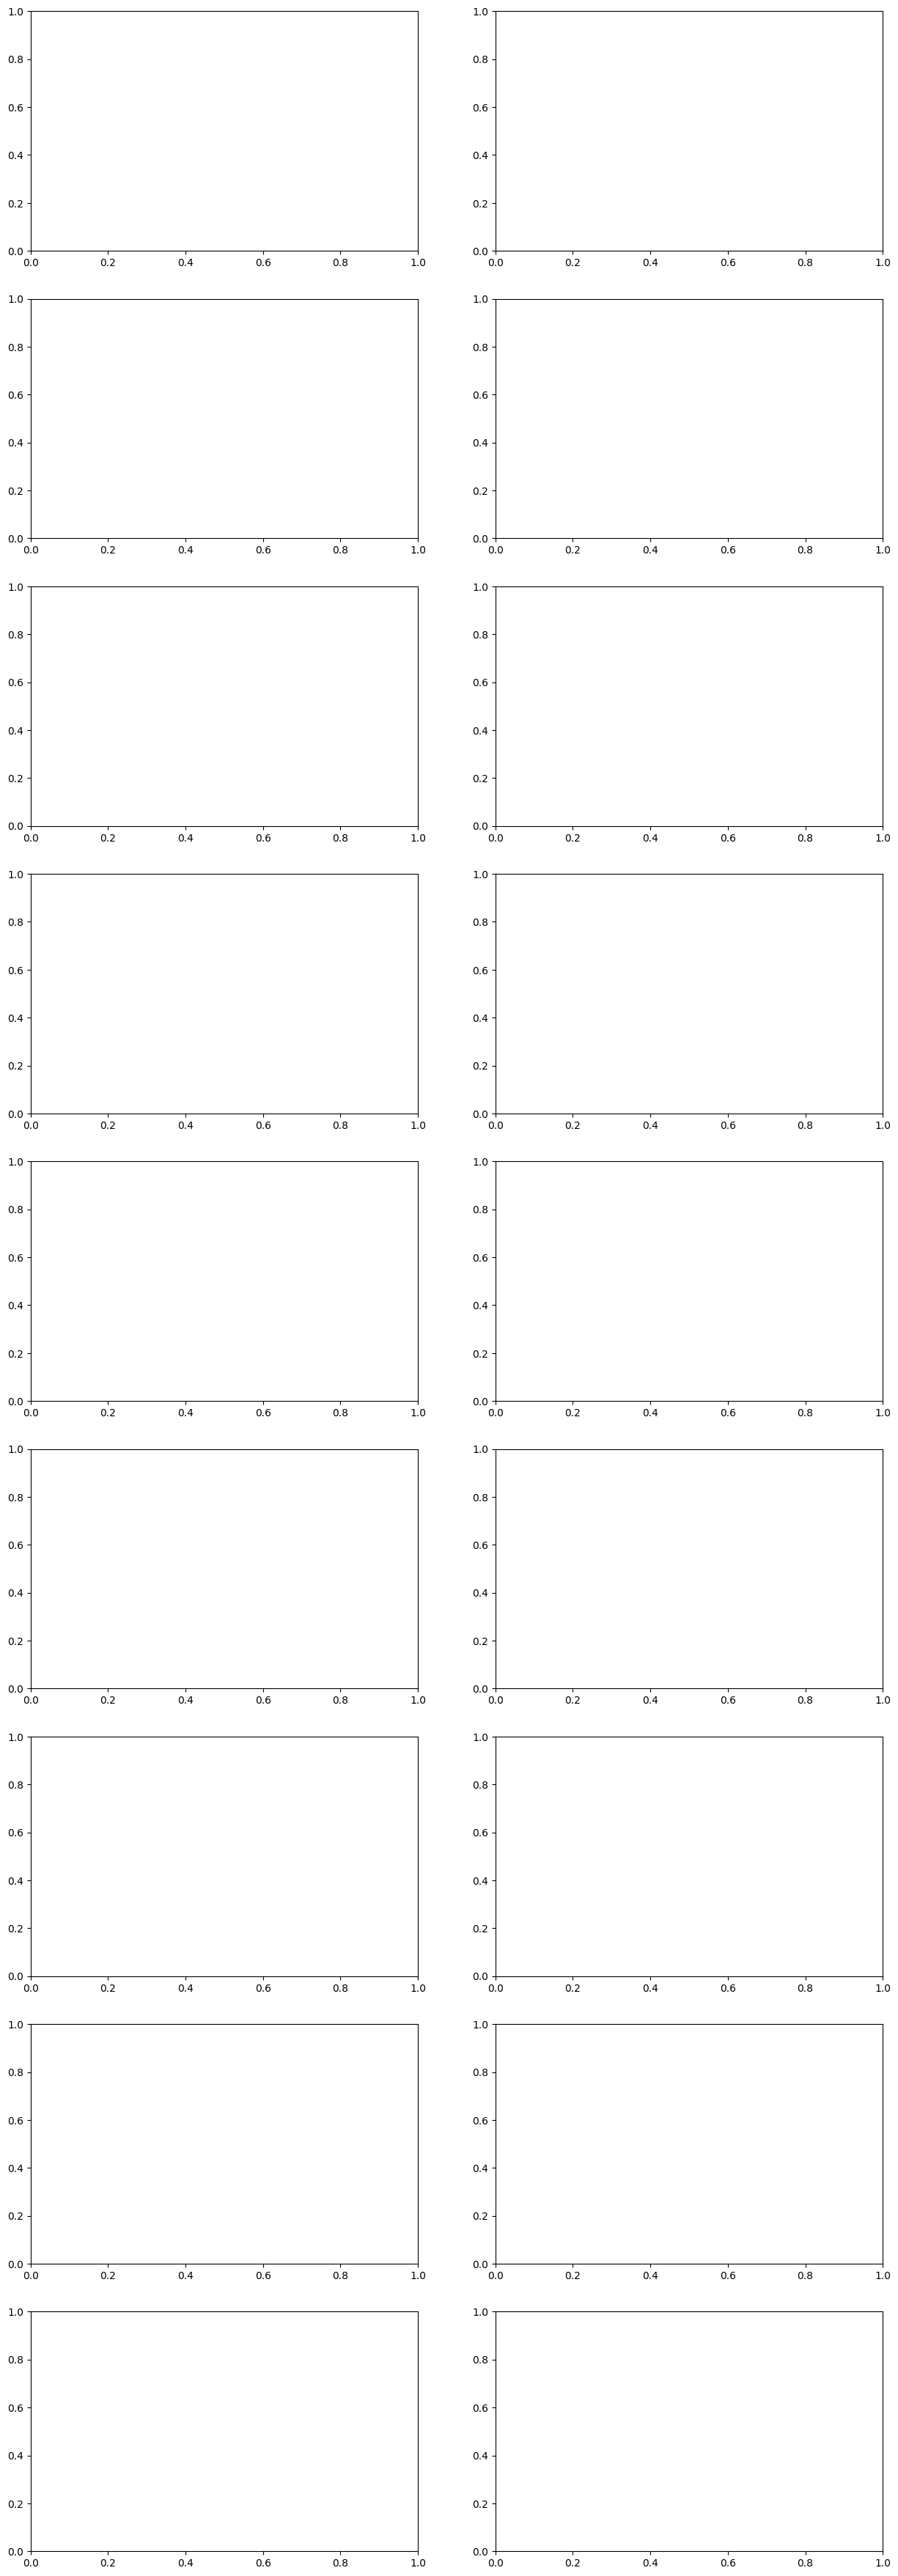

In [1284]:
from nba_api.stats.endpoints import boxscoretraditionalv2
games_data = pd.read_csv('datasets/2019_Players.csv')
team_ids = {'DEN': 1610612743, 'LAL': 1610612747}

# Get unique game_ids, remove the 2 trailing 0s
game_ids = games_data['GAME_ID'].unique()

figsize = (15, 5 * len(game_ids))
fig, axs = plt.subplots(nrows = len(game_ids),
                        ncols =2,
                        # Adjust the height of the subplots based on the number of games
                        figsize= figsize
                        )

# Iterate unique game_id
for i,game_id in enumerate(game_ids):
    
    # Get all rows with this game_id
    game_data = games_data.loc[games_data['GAME_ID'] == game_id]

    # Get networks for both teams
    den_network, lal_network = get_nw_passes([team_ids['DEN'], team_ids['LAL']] , game_data, as_pos=False)

    # Get game date from den_games dataframe
    game_date = den_games.loc[den_games['GAME_ID'] == f"0041900315"].iloc[0]['GAME_DATE']

    den_network.name = f"Passes for Denver Nuggets vs Los Angeles Lakers-{game_date[1].strip()}"
    lal_network.name = f"Passes for Los Angeles Lakers vs Denver Nuggets-{game_date[1].strip()}"

    pos_den_network = transform_to_pos_nw(den_network)
    pos_lal_network = transform_to_pos_nw(lal_network)

    #get_passes_plots(den_network, axs[i, 0])
    #get_passes_plots(lal_network, axs[i, 1])

    get_passes_plots(pos_den_network, axs[i, 0])    
    get_passes_plots(pos_lal_network, axs[i, 1])

    plt.tight_layout()

In [380]:
foul_nw_array = []
team_ids = {'DEN': 1610612743, 'LAL': 1610612747}

# Setup games of interest
#games_list = ['0041900315', '0041900311', '0021900304']
games_list = den_games['GAME_ID'].values

# Filter out games that are not in the games list, sort by date from oldest to newest
interest_games = den_games.loc[den_games['GAME_ID'].isin(games_list)].sort_values(by='GAME_DATE')

# Plot the networks for assists and shots
#team_networks = plot_nw_shots_assists(interest_games, team_ids, plot_name = 'shots_and_assists')
#team_networks_as_pos = plot_nw_shots_assists_as_pos(interest_games, team_ids, plot_name = 'shots_and_assists_as_pos') #TODO


# Plot the networks for fouls
#team_networks = draw_nw_fouls(interest_games, [], team_ids, plot_name = 'fouls.png')

## Helper functions for network statistics


In [381]:
def network_info(multidigraph):
    print(f"Network name: {multidigraph.name}")
    # Get the number of nodes
    num_nodes = multidigraph.number_of_nodes()
    # Get the number of edges
    num_edges = multidigraph.number_of_edges()

    # Get the number of shots and assists
    num_shots = len([(u, v, d) for u, v, d in multidigraph.edges(data=True) if d['action'] == 'shot'])
    num_assists = len([(u, v, d) for u, v, d in multidigraph.edges(data=True) if d['action'] == 'assist'])

    print(multidigraph.edges(data=True))
    # Get the number of made and missed shots
    shots = [(u, v, d) for u, v, d in multidigraph.edges(data=True) if d['action'] == 'shot']
    num_made_shots = np.sum([d['weight'] for u, v, d in shots if v == 1])
    num_missed_shots = np.sum([d['weight'] for u, v, d in shots if v == 2])
    num_free_throws = np.sum([d['weight'] for u, v, d in shots if d['actionType'] == 'freethrow'])


    print(f'Number of nodes: {num_nodes}')
    print(f'Number of edges: {num_edges}')
    print(f'Number of field shot attempts: {num_shots} ({num_made_shots} made, {num_missed_shots} missed)')
    print(f'Number of free throw attempts: {num_free_throws}', f'({num_made_shots} made, {num_missed_shots} missed)')
    print(f'Number of assists: {num_assists}')


def assist_deg_distrib(nw, ax):
    # Get all players but the made and missed nodes
    players = {node:data for node, data in nw.nodes(data=True) if node not in [1, 2]}

    # Get assist degree of players - InDegree
    #assist_degrees = [len(list(edge for frm, to, edge in nw.edges(node, data=True) if edge['action'] == 'assist')) for node in players]
    
    # Get allDegree of players
    assist_degrees = [len(list(edge for frm, to, edge in nw.edges(data=True) if edge['action'] == 'assist' and (frm == node or to==node) )) for node in players]

    # Put player names on the x axis (players -> data -> playerName)
    player_names = [players[node]['playerName'] for node in players]

    # Sort the players by assist degree
    player_names, assist_degrees = zip(*sorted(zip(player_names, assist_degrees), key=lambda x: x[1], reverse=True))

    # Plot the distribution on ax
    ax.bar(player_names, assist_degrees, width=0.5)
    ax.set_title(nw.name)
    ax.set_ylabel('Assist degree')

    # Set yticks more compact
    ax.set_yticks(np.arange(0, max(assist_degrees)+1, 1))

    # Rotate the x axis labels
    ax.set_xticklabels(player_names, rotation=60, fontsize=6)


def weighed_degree_centrality(multi_graph):
    weighted_degree_centrality = {}
    for node in multi_graph.nodes:
        weighted_degree_centrality[node] = sum([data['weight'] for _, _, data in multi_graph.edges(node, data=True)])

    return {k: v for k, v in weighted_degree_centrality.items() if k>2}

def plot_cent(cent, axs, nw, cent_name = 'Centrality', save_file=None):
    

    # Sort the players by centrality
    player_names, centrality = zip(*sorted(cent.items(), key=lambda x: x[1], reverse=True))

    # Swap names from player id to player name
    player_names = [nw.nodes[node]['playerName'] for node in player_names]

    # Ignore the made and missed nodes
    #player_names, centrality = zip(*[(player_name, centrality) for player_name, centrality in zip(player_names, centrality) if player_name not in ['Made', 'Missed']])

    # Plot the distribution on ax
    axs.bar(player_names, centrality, width=0.5)
    axs.set_title(nw.name)
    axs.set_ylabel(cent_name)

    # Set yticks more compact (every 10%)
    axs.set_yticks(np.arange(0, max(centrality), max(centrality)/10))

    # Rotate the x axis labels
    axs.set_xticklabels(player_names, rotation=60, fontsize=6)

    if save_file:
        plt.savefig(save_file)
    
def pagerank_centrality(nw, **kwargs):
    # Get the pagerank centrality
    pagerank_centrality = nx.pagerank(nw)

    return pagerank_centrality

def betweenness_centrality(nw, **kwargs):
    # Get the betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(nw, **kwargs)

    return betweenness_centrality


def edge_density(nw):
    # Get the number of edges
    num_edges = nw.number_of_edges()

    # Get the number of nodes
    num_nodes = nw.number_of_nodes()

    # Get the edge density
    return num_edges / (num_nodes * (num_nodes - 1))

Assist degree distribution for all players

In [382]:
cent_algos = {"Weighed degree centrality": weighed_degree_centrality, "Pagerank Centrality": pagerank_centrality, "Betweenness Centrality": betweenness_centrality}
file_name = False
draw_plots = True

for cent_name, cent_algo in cent_algos.items():
    file_name = f'./plots/centrality/{cent_algo.__name__}.png'
    # Skip if file exists
    if os.path.exists(file_name) and file_name:
        continue

    if draw_plots:
        fig, axs = plt.subplots(nrows = len(interest_games),
                            ncols =2,
                            figsize= (15, 5 * len(interest_games))
                            )
    
    # Add a title to the figure
    fig.suptitle(cent_name)

    for i, (team_id, networks) in enumerate(team_networks.items()):
        for j, (gameId, network) in enumerate(networks.items()):
            # Remove made and missed nodes
            network.remove_nodes_from([1, 2])

            # Get the centrality
            cent = cent_algo(network)
            plot_cent(cent, axs[j, i], network, cent_name=cent_name, save_file=False)


In [383]:
# Dataset created by the script from article https://github.com/AniMadurkar/NBA-Flow-Network-Analysis/tree/main
# Read data from csv
players = pd.read_csv(dataset_path + '/2019_Playoffs_Players.csv')
teams = pd.read_csv(dataset_path + '/2019_Playoffs.csv')
players

,Unnamed: 0,GAME_ID,PLAYER_ID,PLAYER_NAME_LAST_FIRST_home,TEAM_NAME_home,TEAM_ID_home,TEAM_ABBREVIATION_home,PASS_TYPE_home,G_home,PASS_TO_home,...,STL,BLK,TO,PF,PTS,PLUS_MINUS,POSITION,mean,std,Unnamed: 73
0,0.0,41900311.0,2544.0,"James, LeBron",Los Angeles Lakers,1.610613e+09,LAL,made,1.0,"Kuzma, Kyle",...,0,0,3,2,15,15,Forward,0.082776,0.098088,NaN
1,1.0,41900311.0,2544.0,"James, LeBron",Los Angeles Lakers,1.610613e+09,LAL,made,1.0,"Caruso, Alex",...,0,0,3,2,15,15,Forward,0.082776,0.098088,NaN
2,2.0,41900311.0,2544.0,"James, LeBron",Los Angeles Lakers,1.610613e+09,LAL,made,1.0,"Caldwell-Pope, Kentavious",...,0,0,3,2,15,15,Forward,0.082776,0.098088,NaN
3,3.0,41900311.0,2544.0,"James, LeBron",Los Angeles Lakers,1.610613e+09,LAL,made,1.0,"Davis, Anthony",...,0,0,3,2,15,15,Forward,0.082776,0.098088,NaN
4,4.0,41900311.0,2544.0,"James, LeBron",Los Angeles Lakers,1.610613e+09,LAL,made,1.0,"Morris, Markieff",...,0,0,3,2,15,15,Forward,0.082776,0.098088,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,1,2,25,16,Forward,0.082776,0.098088,1.704829
438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,1,2,25,16,Forward,0.082776,0.098088,-0.415710
439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,1,2,25,16,Forward,0.082776,0.098088,0.430466
440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,1,2,25,16,Forward,0.082776,0.098088,-0.415710


In [831]:
# Read pickle
with open(dataset_path + '/player_positions.pickle', 'rb') as f:
    passes = pickle.load(f)
    print(passes)

{203924: ['Forward', 'Jerami Grant'], 200794: ['Forward', 'Paul Millsap'], 203999: ['Center', 'Nikola Jokic'], 203914: ['Guard', 'Gary Harris'], 1627750: ['Guard', 'Jamal Murray'], 1628420: ['Guard', 'Monte Morris'], 203486: ['Forward-Center', 'Mason Plumlee'], 1629008: ['Forward', 'Michael Porter Jr.'], 1628470: ['Forward', 'Torrey Craig'], 1628408: ['Guard-Forward', 'PJ Dozier'], 1628966: ['Forward', 'Keita Bates-Diop'], 1629626: ['Center-Forward', 'Bol Bol'], 203584: ['Guard', 'Troy Daniels'], 2544: ['Forward', 'LeBron James'], 203076: ['Forward-Center', 'Anthony Davis'], 2730: ['Center-Forward', 'Dwight Howard'], 201980: ['Guard', 'Danny Green'], 203484: ['Guard', 'Kentavious Caldwell-Pope'], 200765: ['Guard', 'Rajon Rondo'], 1628398: ['Forward', 'Kyle Kuzma'], 1627936: ['Guard', 'Alex Caruso'], 202693: ['Forward', 'Markieff Morris'], 201580: ['Center-Forward', 'JaVale McGee'], 1626188: ['Guard', 'Quinn Cook'], 201162: ['Forward', 'Jared Dudley'], 2747: ['Guard', 'JR Smith'], 16290